<a href="https://colab.research.google.com/github/balezz/cv_course_fa_mag/blob/main/CodeLab_4_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 4. Семантическая сегментация Unet

### В этом задании Вам предстоит:
1. Реализовать архитектуру Unet на Keras
2. Обучить свою модель на небольшом датасете и сохранить её  

Источник: https://www.tensorflow.org/tutorials/images/segmentation

### Импорт библиотек и загрузка данных

In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
%%bash
wget https://storage.yandexcloud.net/fa-bucket/pets.zip
unzip pets.zip

%%bash
wget https://storage.yandexcloud.net/fa-bucket/pets.zip
unzip pets.zip

In [ ]:
DATA_DIR = 'pets/'
IMG_LIST = os.listdir(DATA_DIR+'img/')

BATCH_SIZE=4

### Создание датасета из объекта python generator

In [6]:
# https://docs-python.ru/tutorial/generatory-python/
def data_gen():
    for img_filename in IMG_LIST:
        img = tf.keras.utils.load_img(DATA_DIR+f'img/{img_filename}')
        index = re.findall(r'\d+', img_filename)[0]
        mask = np.load(DATA_DIR+f'mask/{index}.npy') - 1
        yield img, mask

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator
dataset = tf.data.Dataset.from_generator(
    data_gen,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.int8)),
).cache().batch(BATCH_SIZE)

### Визуализация изображений и масок

In [8]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

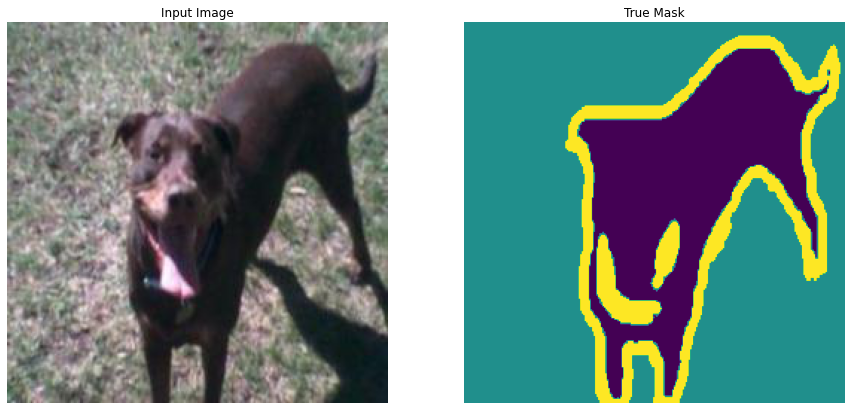

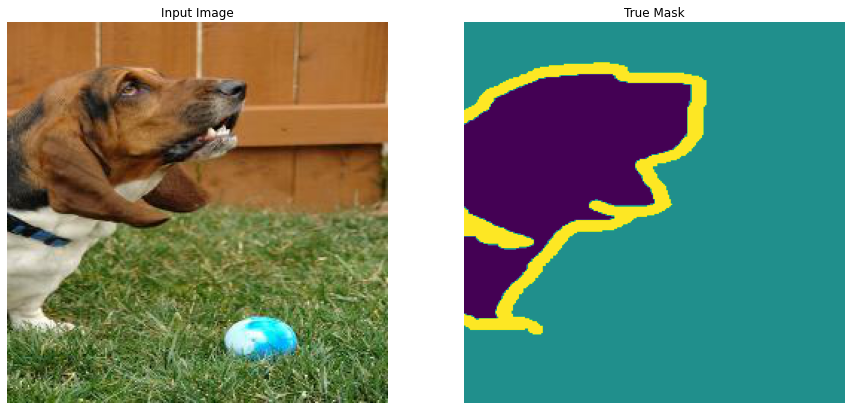

In [9]:
for images, masks in dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### Операция Conv2DTranspose (Upconvolution, upsample)
https://arxiv.org/pdf/1603.07285v1.pdf

In [10]:
x = np.ones((1,5,5,1))
out = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(2,2),
    strides=2,
    kernel_initializer='ones')(x)

In [11]:
out.numpy().reshape(10,10)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

### Архитектура Unet 
<img src='https://raw.githubusercontent.com/shreyaspadhy/UNet-Zoo/master/unet.png'>

С помощью Functional API можно строить более гибкие архитектуры.  
Например, несколько слоев можно объединить друг с другом с помощью обычных python - функций. 

In [12]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 
                      kernel_size=3, 
                      padding = "same", 
                      activation = "relu", 
                      kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 
                      kernel_size=3,
                      padding = "same",
                      activation = "relu",
                      kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    conv_features = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(conv_features)
    return conv_features, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 
                               kernel_size=3, 
                               strides=2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

### Задание 1. Реализуйте архитектуру Unet на Keras 

Не забудьте про нормализацию входных данных!

In [13]:
 # inputs
inputs = layers.Input(shape=(256,256,3))

# encoder: contracting path - downsample
# downsample
f1, p1 = downsample_block(inputs, 256)

# bottleneck
bottleneck = double_conv_block(p1, 1024)

# decoder: expanding path - upsample
#  upsample
u1 = upsample_block(bottleneck, f1, 256)

# outputs
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u1)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

In [14]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy")

### Не забываем проверить модель на малой выборке данных 

In [ ]:
model_history = unet_model.fit(
    dataset.take(4).cache(), 
    epochs=10)

Epoch 1/10
4/4 [==============================] - 28s 2s/step - loss: 2041.6543 - accuracy: 0.3985
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 19.6017 - accuracy: 0.4718
Epoch 3/10
1/4 [======>.......................] - ETA: 4s - loss: 7.3534 - accuracy: 0.6709

### Вопрос 1. 

Чему равно матожидание начального значения segmentation loss, при условии что для каждого пикселя CE_loss суммируются?  
**Ответ:** 

### Задание 2. Обучите Unet и сохраните модель 

За использование аугментаций для снижения переобучения будут начислены дополнительные баллы.

In [ ]:
TRAIN_STEPS = int(len(IMG_LIST) * 0.8) // BATCH_SIZE
TEST_STEPS  = int(len(IMG_LIST) * 0.2) // BATCH_SIZE

train_ds = dataset.take(TRAIN_STEPS).cache()
test_ds = dataset.skip(TRAIN_STEPS).take(TEST_STEPS).cache().repeat()

In [ ]:
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
unet_model.compile(...)

In [ ]:
# todo read the docs
model_history = unet_model.fit(
    train_ds, 
    epochs=10,
    test_ds)

In [ ]:
unet_model.save(...)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Проверим работу модели на выборках train и test

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = unet_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

show_predictions(train_ds)

In [ ]:
show_predictions(test_ds, 3)